In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.optim.lr_scheduler import SequentialLR, LinearLR, MultiStepLR

In [ ]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128


train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.482, 0.4465], std=[0.247, 0.2435, 0.2616]),
])

test_transform = transforms.ToTensor()

#Downloads datasets
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_dataset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transform),
    val_dataset.indices
)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [3]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


In [4]:
#Defines Convolutional Neural Network

class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.reslayers = nn.ModuleList()

        #Sets size of network. Paper uses n = {3,5,7,9}, but starting with smallest at 3
        n = 3

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=True))

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=True))

        for _ in range(n):
            self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=8,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = self.out(x)
        
        return out

In [5]:
def he_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 50
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if (batch_index+1) % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0


    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(valloader)
    avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [7]:
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Train Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Train Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Val Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Val Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Batch Number')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch100, Loss: 2.230, Accuracy: 21.0%
Batch200, Loss: 1.908, Accuracy: 27.5%
Batch300, Loss: 1.801, Accuracy: 32.3%
Batch400, Loss: 1.703, Accuracy: 35.7%
Batch500, Loss: 1.661, Accuracy: 37.2%
Batch600, Loss: 1.635, Accuracy: 38.2%
Batch700, Loss: 1.619, Accuracy: 39.0%
Val Loss: 3.257, Val Accuracy: 20.4%
*****************************************



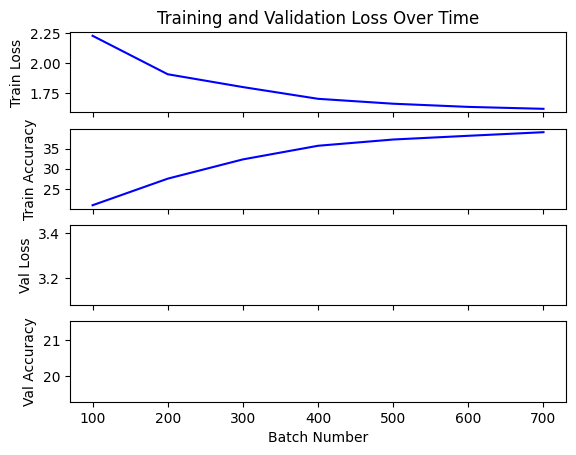

Epoch 2
Batch100, Loss: 1.875, Accuracy: 30.2%
Batch200, Loss: 1.662, Accuracy: 38.1%
Batch300, Loss: 1.540, Accuracy: 43.3%
Batch400, Loss: 1.457, Accuracy: 45.3%
Batch500, Loss: 1.400, Accuracy: 48.6%
Batch600, Loss: 1.347, Accuracy: 51.4%
Batch700, Loss: 1.267, Accuracy: 53.9%
Val Loss: 3.257, Val Accuracy: 18.3%
*****************************************



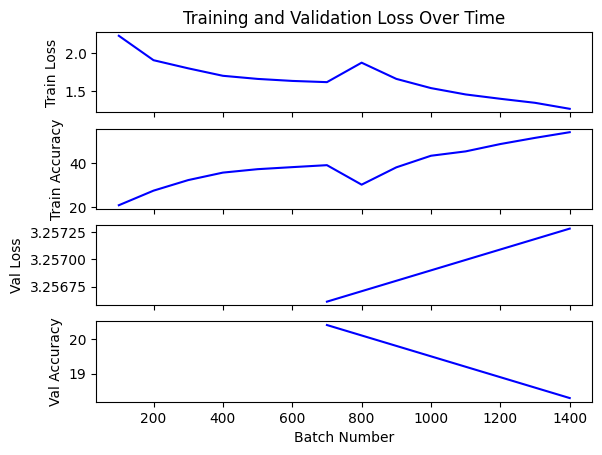

Epoch 3
Batch100, Loss: 1.427, Accuracy: 48.1%
Batch200, Loss: 1.306, Accuracy: 53.1%
Batch300, Loss: 1.276, Accuracy: 54.0%
Batch400, Loss: 1.192, Accuracy: 56.9%
Batch500, Loss: 1.154, Accuracy: 58.0%
Batch600, Loss: 1.128, Accuracy: 59.2%
Batch700, Loss: 1.075, Accuracy: 61.1%
Val Loss: 3.728, Val Accuracy: 12.7%
*****************************************



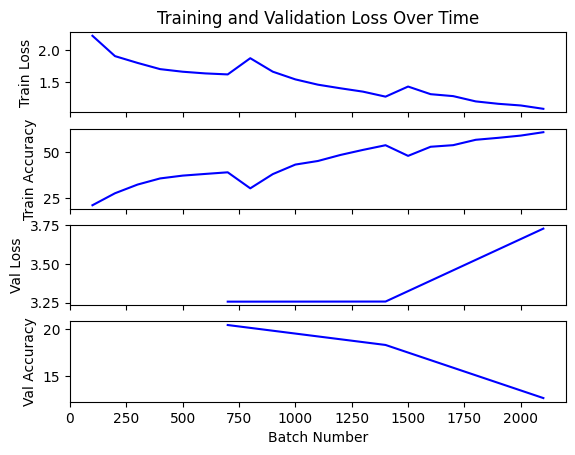

Epoch 4
Batch100, Loss: 1.208, Accuracy: 56.6%
Batch200, Loss: 1.105, Accuracy: 61.3%
Batch300, Loss: 1.059, Accuracy: 62.2%
Batch400, Loss: 0.998, Accuracy: 64.9%
Batch500, Loss: 1.023, Accuracy: 64.0%
Batch600, Loss: 0.972, Accuracy: 65.8%
Batch700, Loss: 0.968, Accuracy: 65.2%
Val Loss: 2.598, Val Accuracy: 21.8%
*****************************************



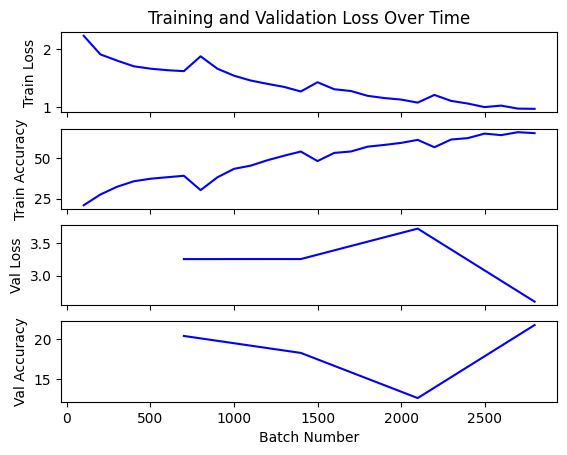

Epoch 5
Batch100, Loss: 1.006, Accuracy: 64.8%
Batch200, Loss: 0.989, Accuracy: 65.5%
Batch300, Loss: 0.960, Accuracy: 66.5%
Batch400, Loss: 0.968, Accuracy: 66.3%
Batch500, Loss: 0.904, Accuracy: 68.6%
Batch600, Loss: 0.922, Accuracy: 68.2%
Batch700, Loss: 0.910, Accuracy: 68.3%
Val Loss: 1.982, Val Accuracy: 32.1%
*****************************************



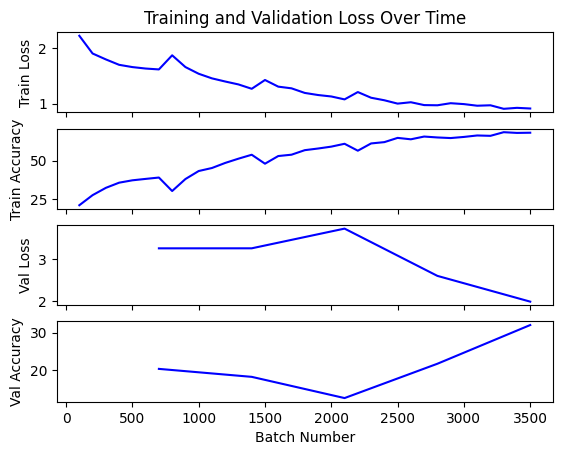

Epoch 6
Batch100, Loss: 0.939, Accuracy: 67.2%
Batch200, Loss: 0.935, Accuracy: 67.5%
Batch300, Loss: 0.918, Accuracy: 68.4%
Batch400, Loss: 0.940, Accuracy: 67.8%
Batch500, Loss: 0.931, Accuracy: 67.4%
Batch600, Loss: 0.870, Accuracy: 69.7%
Batch700, Loss: 0.904, Accuracy: 68.2%
Val Loss: 2.653, Val Accuracy: 22.6%
*****************************************



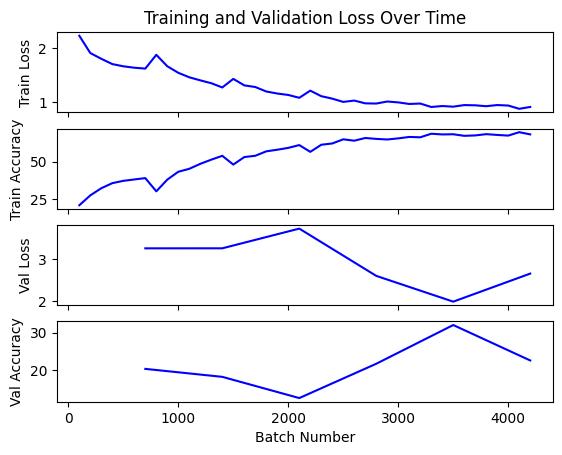

Epoch 7
Batch100, Loss: 0.859, Accuracy: 70.9%
Batch200, Loss: 0.862, Accuracy: 70.5%
Batch300, Loss: 0.831, Accuracy: 71.7%
Batch400, Loss: 0.827, Accuracy: 71.5%
Batch500, Loss: 0.817, Accuracy: 71.9%
Batch600, Loss: 0.817, Accuracy: 71.1%
Batch700, Loss: 0.789, Accuracy: 72.9%
Val Loss: 2.785, Val Accuracy: 19.1%
*****************************************



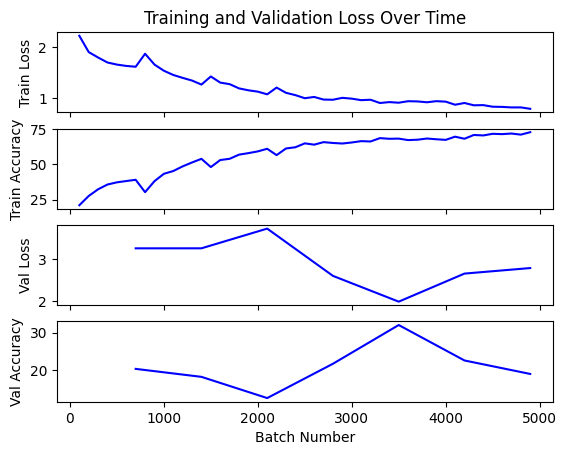

Epoch 8
Batch100, Loss: 0.803, Accuracy: 72.5%
Batch200, Loss: 0.794, Accuracy: 72.6%
Batch300, Loss: 0.758, Accuracy: 73.8%
Batch400, Loss: 0.743, Accuracy: 74.3%
Batch500, Loss: 0.774, Accuracy: 73.6%
Batch600, Loss: 0.760, Accuracy: 74.2%
Batch700, Loss: 0.764, Accuracy: 73.3%
Val Loss: 2.411, Val Accuracy: 26.7%
*****************************************



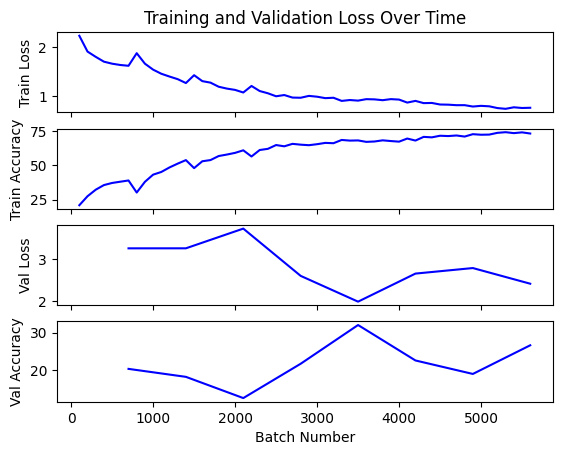

Epoch 9
Batch100, Loss: 0.758, Accuracy: 73.7%
Batch200, Loss: 0.733, Accuracy: 74.8%
Batch300, Loss: 0.728, Accuracy: 74.6%
Batch400, Loss: 0.744, Accuracy: 74.3%
Batch500, Loss: 0.729, Accuracy: 74.6%
Batch600, Loss: 0.731, Accuracy: 75.1%
Batch700, Loss: 0.709, Accuracy: 75.1%
Val Loss: 2.646, Val Accuracy: 23.1%
*****************************************



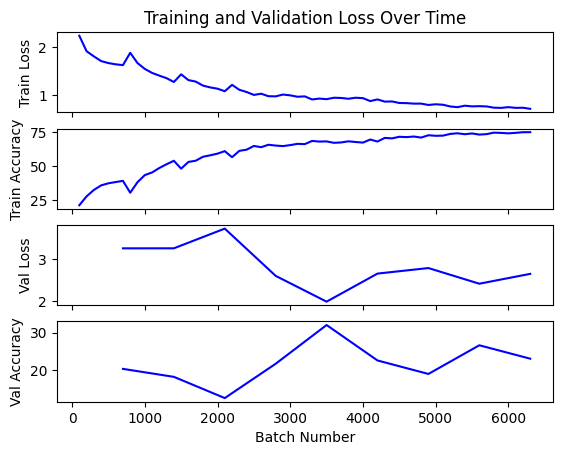

Epoch 10
Batch100, Loss: 0.710, Accuracy: 75.4%
Batch200, Loss: 0.714, Accuracy: 75.7%
Batch300, Loss: 0.689, Accuracy: 75.8%
Batch400, Loss: 0.684, Accuracy: 76.2%
Batch500, Loss: 0.709, Accuracy: 75.4%
Batch600, Loss: 0.694, Accuracy: 76.2%
Batch700, Loss: 0.682, Accuracy: 76.5%
Val Loss: 2.292, Val Accuracy: 28.8%
*****************************************



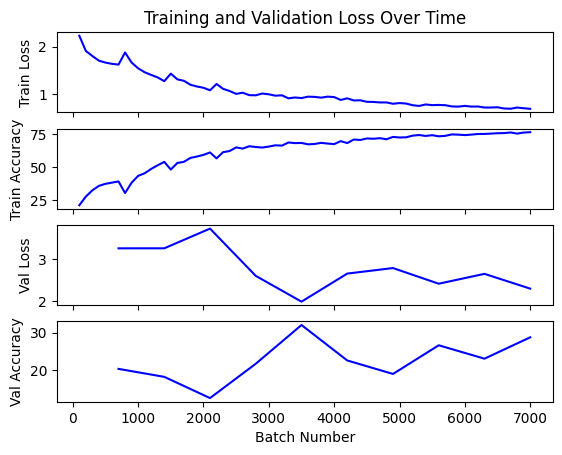

Epoch 11
Batch100, Loss: 0.686, Accuracy: 76.5%
Batch200, Loss: 0.676, Accuracy: 77.1%
Batch300, Loss: 0.666, Accuracy: 77.6%
Batch400, Loss: 0.634, Accuracy: 78.7%
Batch500, Loss: 0.690, Accuracy: 75.8%
Batch600, Loss: 0.674, Accuracy: 77.0%
Batch700, Loss: 0.692, Accuracy: 76.3%
Val Loss: 2.452, Val Accuracy: 30.9%
*****************************************



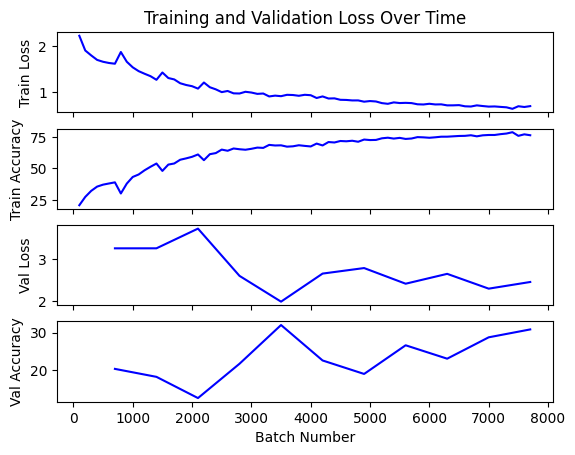

Epoch 12
Batch100, Loss: 0.695, Accuracy: 76.7%
Batch200, Loss: 0.652, Accuracy: 77.6%
Batch300, Loss: 0.639, Accuracy: 77.3%
Batch400, Loss: 0.651, Accuracy: 77.1%
Batch500, Loss: 0.646, Accuracy: 77.6%
Batch600, Loss: 0.640, Accuracy: 78.1%
Batch700, Loss: 0.647, Accuracy: 77.5%
Val Loss: 2.431, Val Accuracy: 27.7%
*****************************************



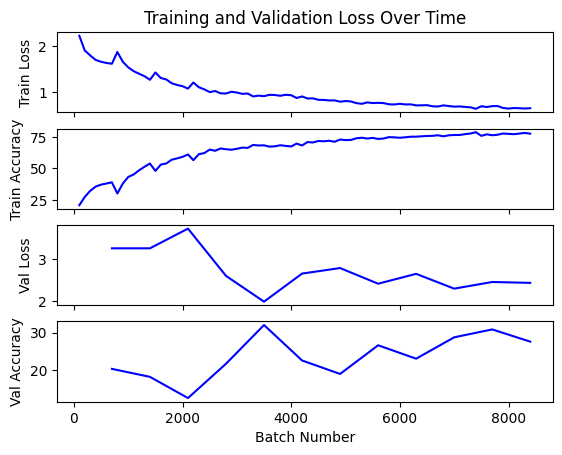

Epoch 13
Batch100, Loss: 0.640, Accuracy: 77.7%
Batch200, Loss: 0.644, Accuracy: 78.3%
Batch300, Loss: 0.632, Accuracy: 78.8%
Batch400, Loss: 0.629, Accuracy: 78.7%
Batch500, Loss: 0.620, Accuracy: 78.8%
Batch600, Loss: 0.621, Accuracy: 78.7%
Batch700, Loss: 0.641, Accuracy: 78.3%
Val Loss: 2.102, Val Accuracy: 32.2%
*****************************************



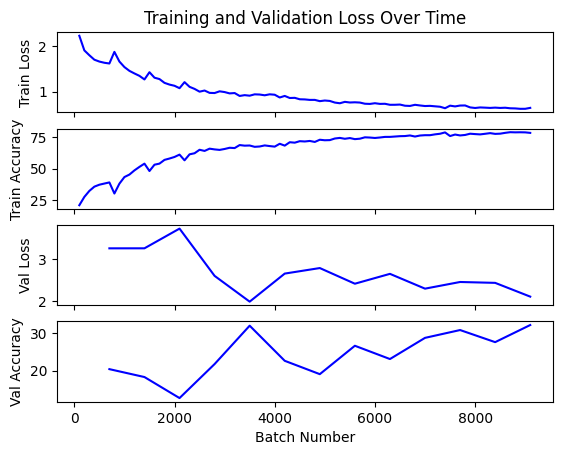

Epoch 14
Batch100, Loss: 0.629, Accuracy: 78.5%
Batch200, Loss: 0.612, Accuracy: 78.7%
Batch300, Loss: 0.631, Accuracy: 78.0%
Batch400, Loss: 0.620, Accuracy: 78.4%
Batch500, Loss: 0.598, Accuracy: 79.5%
Batch600, Loss: 0.627, Accuracy: 78.0%
Batch700, Loss: 0.584, Accuracy: 79.9%
Val Loss: 2.715, Val Accuracy: 32.5%
*****************************************



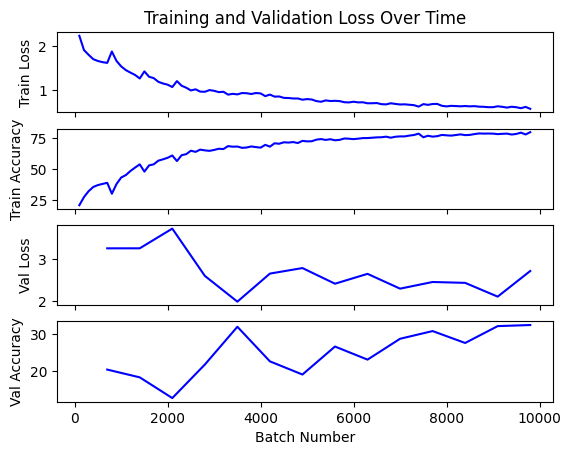

Epoch 15
Batch100, Loss: 0.612, Accuracy: 79.4%
Batch200, Loss: 0.577, Accuracy: 80.2%
Batch300, Loss: 0.588, Accuracy: 79.7%
Batch400, Loss: 0.611, Accuracy: 78.6%
Batch500, Loss: 0.610, Accuracy: 79.4%
Batch600, Loss: 0.604, Accuracy: 79.3%
Batch700, Loss: 0.606, Accuracy: 79.3%
Val Loss: 2.729, Val Accuracy: 27.0%
*****************************************



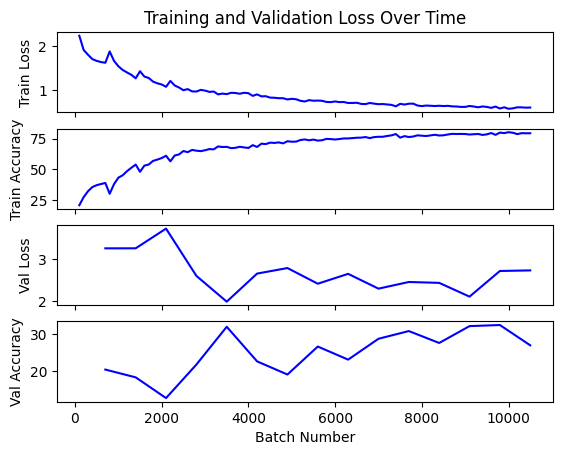

Epoch 16
Batch100, Loss: 0.598, Accuracy: 79.4%
Batch200, Loss: 0.607, Accuracy: 78.4%
Batch300, Loss: 0.563, Accuracy: 80.5%
Batch400, Loss: 0.571, Accuracy: 80.4%
Batch500, Loss: 0.589, Accuracy: 79.5%
Batch600, Loss: 0.567, Accuracy: 80.5%
Batch700, Loss: 0.573, Accuracy: 80.6%
Val Loss: 2.538, Val Accuracy: 20.5%
*****************************************



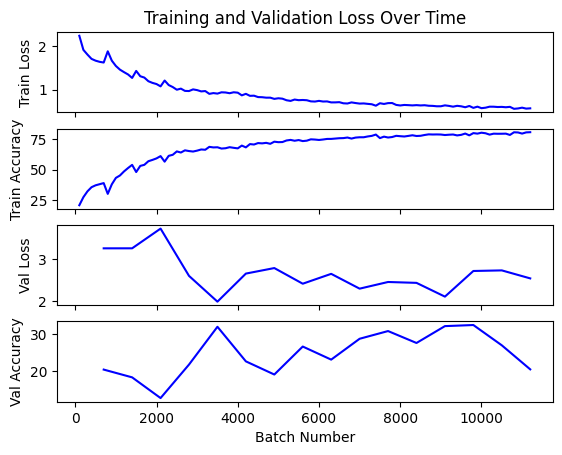

Epoch 17
Batch100, Loss: 0.556, Accuracy: 80.7%
Batch200, Loss: 0.580, Accuracy: 79.9%
Batch300, Loss: 0.612, Accuracy: 79.5%
Batch400, Loss: 0.562, Accuracy: 80.5%
Batch500, Loss: 0.572, Accuracy: 80.5%
Batch600, Loss: 0.551, Accuracy: 81.2%
Batch700, Loss: 0.560, Accuracy: 80.5%
Val Loss: 2.350, Val Accuracy: 29.5%
*****************************************



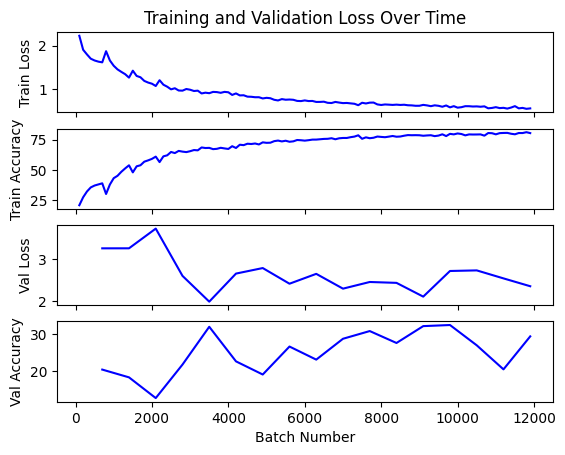

Epoch 18
Batch100, Loss: 0.566, Accuracy: 80.2%
Batch200, Loss: 0.561, Accuracy: 80.6%
Batch300, Loss: 0.554, Accuracy: 81.1%
Batch400, Loss: 0.539, Accuracy: 81.1%
Batch500, Loss: 0.559, Accuracy: 81.1%
Batch600, Loss: 0.585, Accuracy: 79.4%
Batch700, Loss: 0.556, Accuracy: 80.8%
Val Loss: 2.627, Val Accuracy: 22.2%
*****************************************



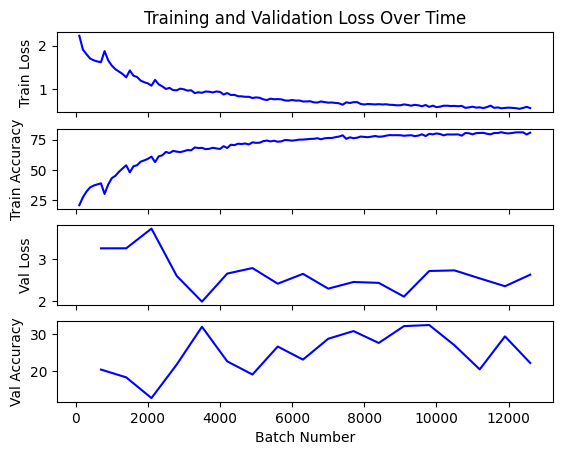

Epoch 19
Batch100, Loss: 0.564, Accuracy: 80.5%
Batch200, Loss: 0.553, Accuracy: 80.7%
Batch300, Loss: 0.562, Accuracy: 80.4%
Batch400, Loss: 0.541, Accuracy: 81.7%
Batch500, Loss: 0.566, Accuracy: 80.4%
Batch600, Loss: 0.559, Accuracy: 81.0%
Batch700, Loss: 0.552, Accuracy: 81.2%
Val Loss: 2.435, Val Accuracy: 32.8%
*****************************************



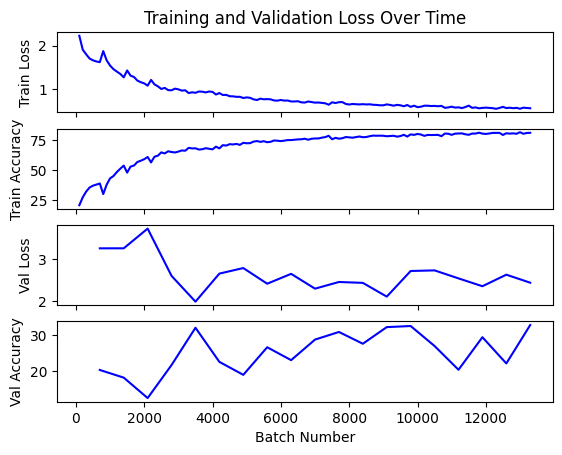

Epoch 20
Batch100, Loss: 0.577, Accuracy: 79.8%
Batch200, Loss: 0.558, Accuracy: 80.7%
Batch300, Loss: 0.550, Accuracy: 81.0%
Batch400, Loss: 0.562, Accuracy: 81.4%
Batch500, Loss: 0.516, Accuracy: 82.1%
Batch600, Loss: 0.532, Accuracy: 81.6%
Batch700, Loss: 0.564, Accuracy: 80.4%
Val Loss: 2.057, Val Accuracy: 34.6%
*****************************************



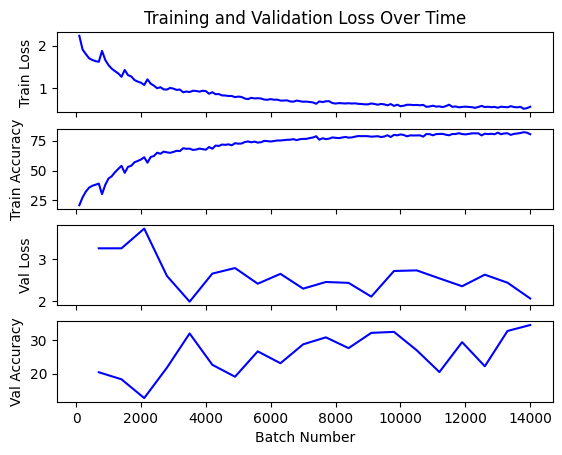

Epoch 21
Batch100, Loss: 0.536, Accuracy: 81.3%
Batch200, Loss: 0.543, Accuracy: 81.7%
Batch300, Loss: 0.528, Accuracy: 81.9%
Batch400, Loss: 0.537, Accuracy: 81.6%
Batch500, Loss: 0.534, Accuracy: 81.6%
Batch600, Loss: 0.547, Accuracy: 80.7%
Batch700, Loss: 0.536, Accuracy: 82.0%
Val Loss: 2.225, Val Accuracy: 31.4%
*****************************************



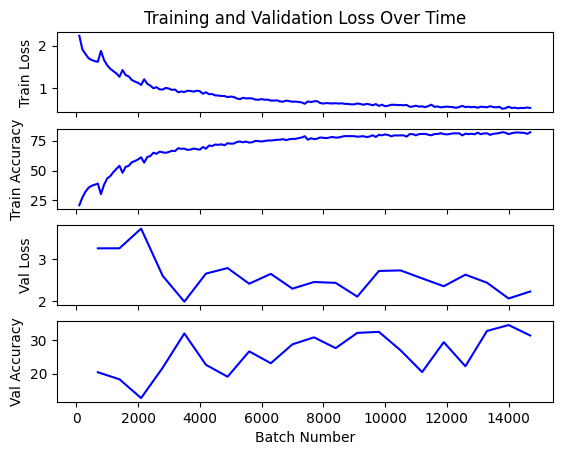

Epoch 22
Batch100, Loss: 0.545, Accuracy: 81.4%
Batch200, Loss: 0.529, Accuracy: 81.7%
Batch300, Loss: 0.536, Accuracy: 81.6%
Batch400, Loss: 0.527, Accuracy: 82.7%
Batch500, Loss: 0.542, Accuracy: 81.0%
Batch600, Loss: 0.514, Accuracy: 82.6%
Batch700, Loss: 0.527, Accuracy: 81.6%
Val Loss: 2.013, Val Accuracy: 35.4%
*****************************************



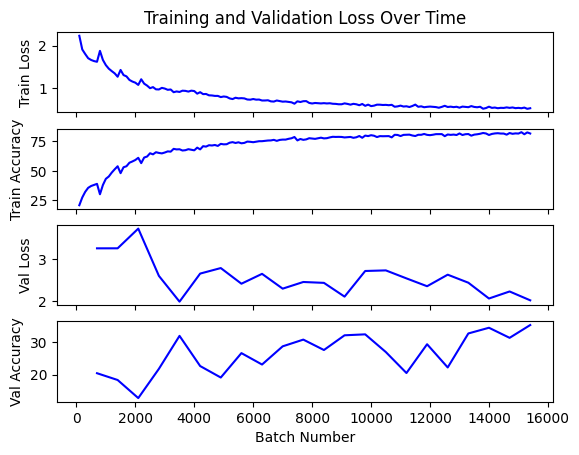

Epoch 23
Batch100, Loss: 0.559, Accuracy: 80.7%
Batch200, Loss: 0.526, Accuracy: 81.9%
Batch300, Loss: 0.499, Accuracy: 82.2%
Batch400, Loss: 0.513, Accuracy: 82.2%
Batch500, Loss: 0.535, Accuracy: 80.9%
Batch600, Loss: 0.554, Accuracy: 80.8%
Batch700, Loss: 0.540, Accuracy: 81.3%
Val Loss: 2.099, Val Accuracy: 36.7%
*****************************************



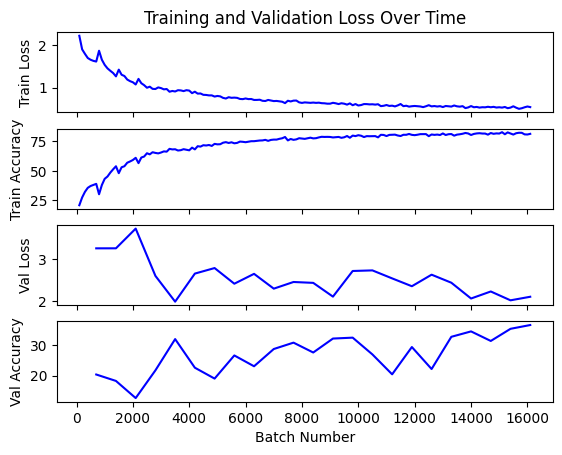

Epoch 24
Batch100, Loss: 0.524, Accuracy: 81.5%
Batch200, Loss: 0.519, Accuracy: 82.0%
Batch300, Loss: 0.517, Accuracy: 82.4%
Batch400, Loss: 0.519, Accuracy: 82.1%
Batch500, Loss: 0.511, Accuracy: 82.6%
Batch600, Loss: 0.509, Accuracy: 82.5%
Batch700, Loss: 0.524, Accuracy: 82.6%
Val Loss: 2.734, Val Accuracy: 18.8%
*****************************************



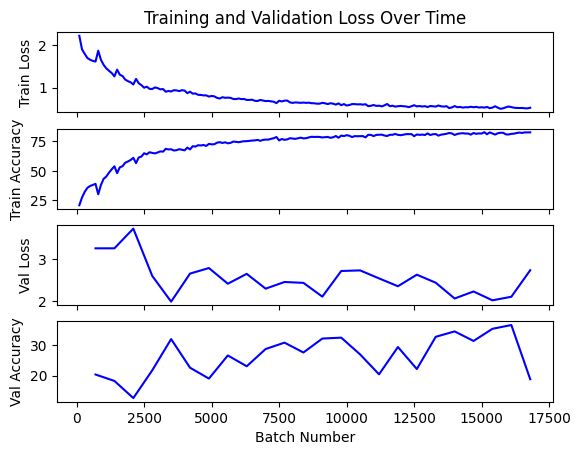

Epoch 25
Batch100, Loss: 0.505, Accuracy: 82.5%
Batch200, Loss: 0.508, Accuracy: 82.3%
Batch300, Loss: 0.495, Accuracy: 83.2%
Batch400, Loss: 0.502, Accuracy: 82.1%
Batch500, Loss: 0.507, Accuracy: 82.5%
Batch600, Loss: 0.495, Accuracy: 82.7%
Batch700, Loss: 0.523, Accuracy: 82.5%
Val Loss: 2.212, Val Accuracy: 30.9%
*****************************************



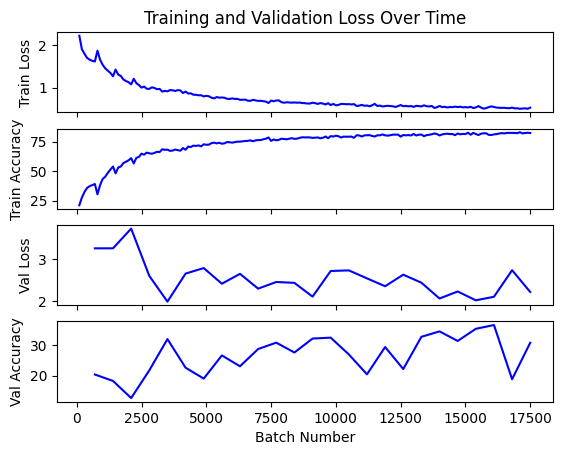

Epoch 26
Batch100, Loss: 0.428, Accuracy: 85.2%
Batch200, Loss: 0.374, Accuracy: 86.9%
Batch300, Loss: 0.368, Accuracy: 87.3%
Batch400, Loss: 0.345, Accuracy: 87.9%
Batch500, Loss: 0.343, Accuracy: 88.3%
Batch600, Loss: 0.337, Accuracy: 88.4%
Batch700, Loss: 0.343, Accuracy: 88.1%
Val Loss: 1.714, Val Accuracy: 42.4%
*****************************************



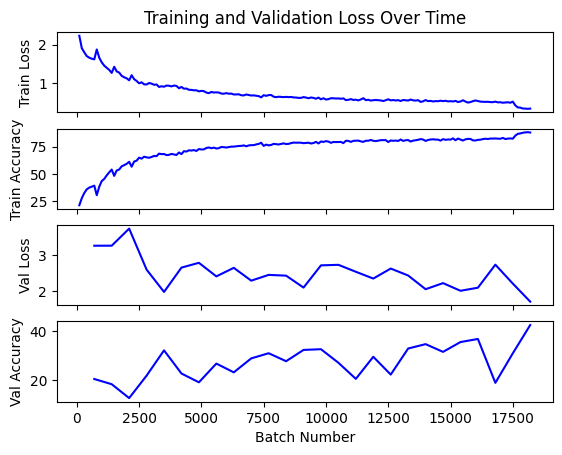

Epoch 27
Batch100, Loss: 0.313, Accuracy: 89.5%
Batch200, Loss: 0.327, Accuracy: 88.8%
Batch300, Loss: 0.308, Accuracy: 89.7%
Batch400, Loss: 0.316, Accuracy: 88.8%
Batch500, Loss: 0.311, Accuracy: 89.3%
Batch600, Loss: 0.317, Accuracy: 89.0%
Batch700, Loss: 0.309, Accuracy: 89.5%
Val Loss: 1.864, Val Accuracy: 40.0%
*****************************************



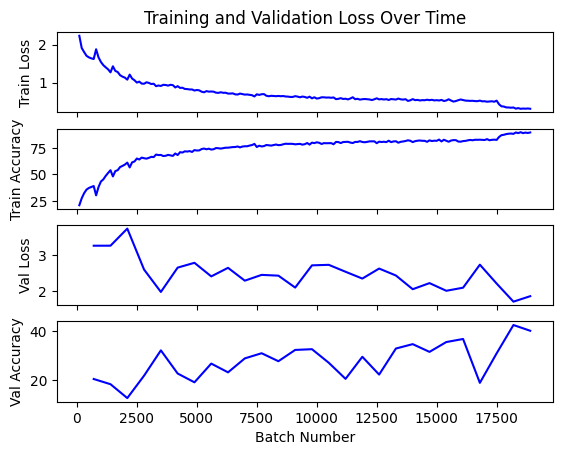

Epoch 28
Batch100, Loss: 0.307, Accuracy: 89.3%
Batch200, Loss: 0.293, Accuracy: 89.9%
Batch300, Loss: 0.297, Accuracy: 89.8%
Batch400, Loss: 0.293, Accuracy: 90.1%
Batch500, Loss: 0.319, Accuracy: 89.3%
Batch600, Loss: 0.282, Accuracy: 90.2%
Batch700, Loss: 0.290, Accuracy: 89.8%
Val Loss: 1.601, Val Accuracy: 48.7%
*****************************************



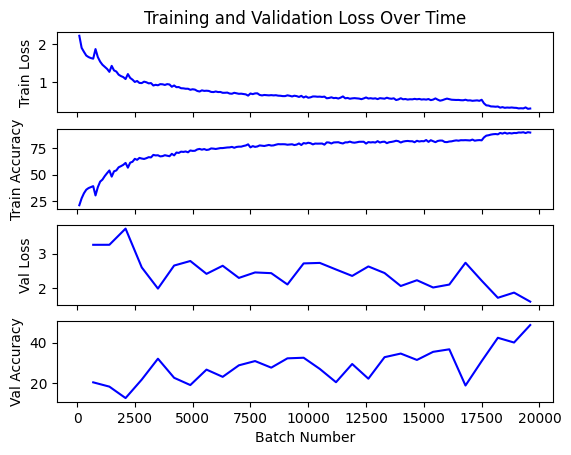

Epoch 29
Batch100, Loss: 0.281, Accuracy: 90.3%
Batch200, Loss: 0.289, Accuracy: 90.3%
Batch300, Loss: 0.284, Accuracy: 90.0%
Batch400, Loss: 0.271, Accuracy: 90.9%
Batch500, Loss: 0.296, Accuracy: 89.8%
Batch600, Loss: 0.287, Accuracy: 90.2%
Batch700, Loss: 0.275, Accuracy: 90.4%
Val Loss: 1.676, Val Accuracy: 46.3%
*****************************************



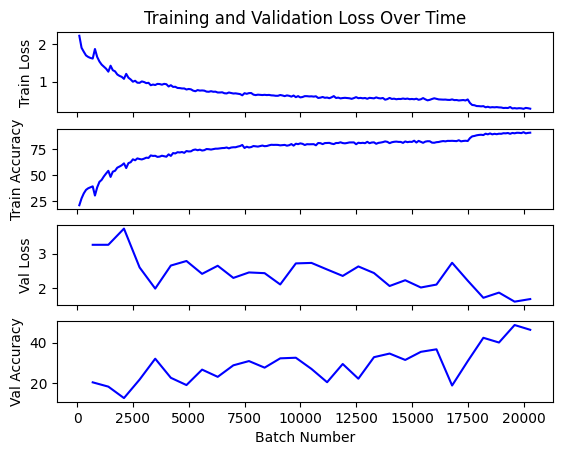

Epoch 30
Batch100, Loss: 0.266, Accuracy: 90.7%
Batch200, Loss: 0.275, Accuracy: 90.2%
Batch300, Loss: 0.265, Accuracy: 90.7%
Batch400, Loss: 0.261, Accuracy: 90.9%
Batch500, Loss: 0.269, Accuracy: 90.6%
Batch600, Loss: 0.281, Accuracy: 90.2%
Batch700, Loss: 0.279, Accuracy: 90.3%
Val Loss: 1.606, Val Accuracy: 50.6%
*****************************************



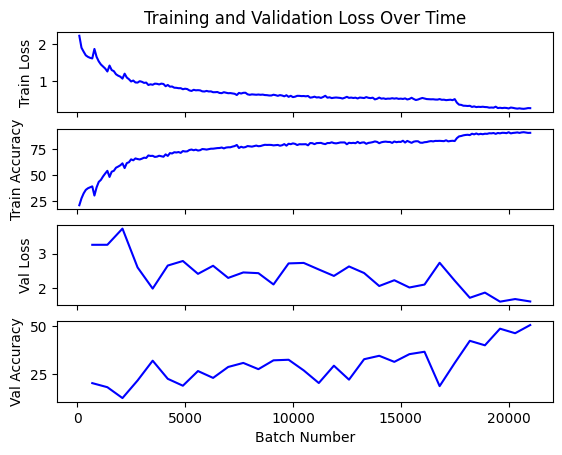

Epoch 31
Batch100, Loss: 0.262, Accuracy: 90.7%
Batch200, Loss: 0.277, Accuracy: 90.6%
Batch300, Loss: 0.255, Accuracy: 91.4%
Batch400, Loss: 0.256, Accuracy: 90.8%
Batch500, Loss: 0.262, Accuracy: 91.1%
Batch600, Loss: 0.274, Accuracy: 90.5%
Batch700, Loss: 0.280, Accuracy: 90.2%
Val Loss: 1.640, Val Accuracy: 47.3%
*****************************************



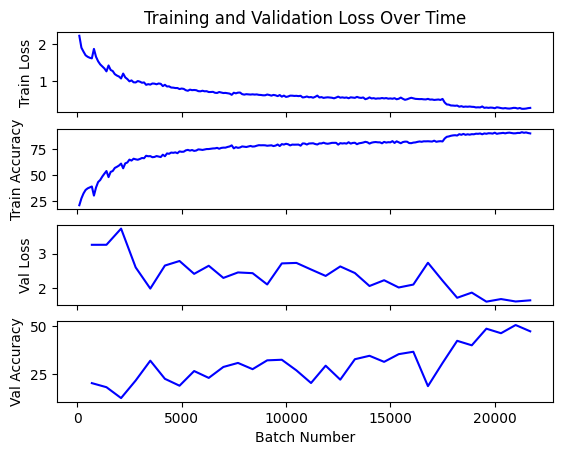

Epoch 32
Batch100, Loss: 0.242, Accuracy: 91.7%
Batch200, Loss: 0.263, Accuracy: 91.0%
Batch300, Loss: 0.264, Accuracy: 90.5%
Batch400, Loss: 0.248, Accuracy: 91.7%
Batch500, Loss: 0.255, Accuracy: 91.2%
Batch600, Loss: 0.257, Accuracy: 91.3%
Batch700, Loss: 0.256, Accuracy: 91.2%
Val Loss: 1.767, Val Accuracy: 45.3%
*****************************************



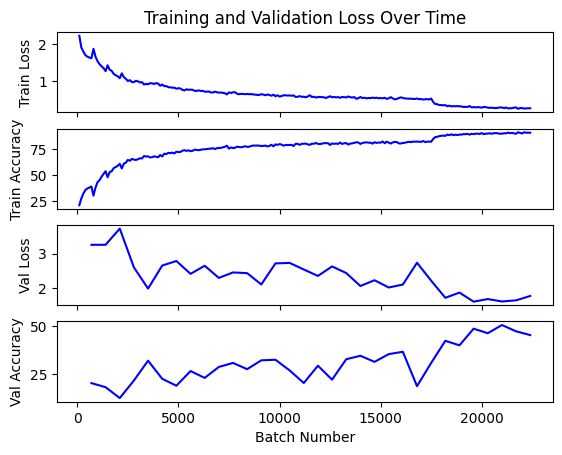

Epoch 33
Batch100, Loss: 0.240, Accuracy: 91.4%
Batch200, Loss: 0.249, Accuracy: 91.3%
Batch300, Loss: 0.235, Accuracy: 91.7%
Batch400, Loss: 0.230, Accuracy: 91.9%
Batch500, Loss: 0.258, Accuracy: 91.5%
Batch600, Loss: 0.251, Accuracy: 91.3%
Batch700, Loss: 0.256, Accuracy: 91.1%
Val Loss: 1.674, Val Accuracy: 47.2%
*****************************************



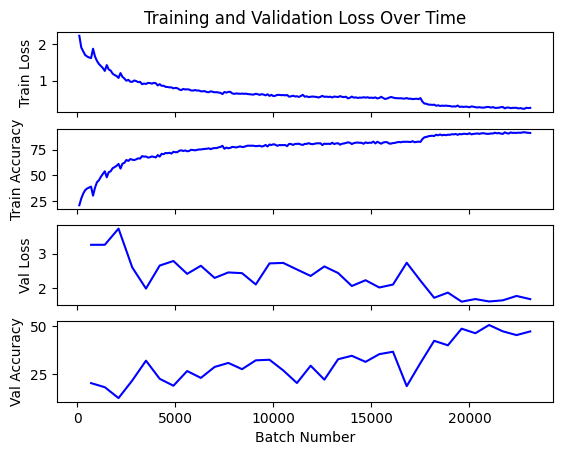

Epoch 34
Batch100, Loss: 0.238, Accuracy: 91.4%
Batch200, Loss: 0.254, Accuracy: 91.1%
Batch300, Loss: 0.240, Accuracy: 91.8%
Batch400, Loss: 0.240, Accuracy: 91.8%
Batch500, Loss: 0.235, Accuracy: 91.8%
Batch600, Loss: 0.238, Accuracy: 91.5%
Batch700, Loss: 0.253, Accuracy: 91.3%
Val Loss: 1.778, Val Accuracy: 44.7%
*****************************************



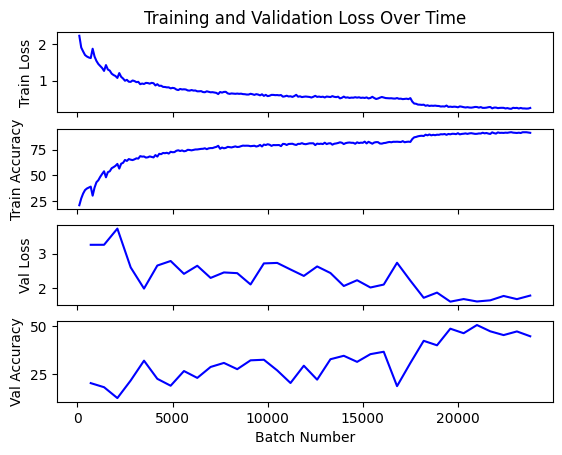

Epoch 35
Batch100, Loss: 0.223, Accuracy: 92.0%
Batch200, Loss: 0.230, Accuracy: 91.9%
Batch300, Loss: 0.231, Accuracy: 91.8%
Batch400, Loss: 0.220, Accuracy: 92.2%
Batch500, Loss: 0.235, Accuracy: 91.9%
Batch600, Loss: 0.237, Accuracy: 91.7%
Batch700, Loss: 0.244, Accuracy: 91.3%
Val Loss: 1.854, Val Accuracy: 44.0%
*****************************************



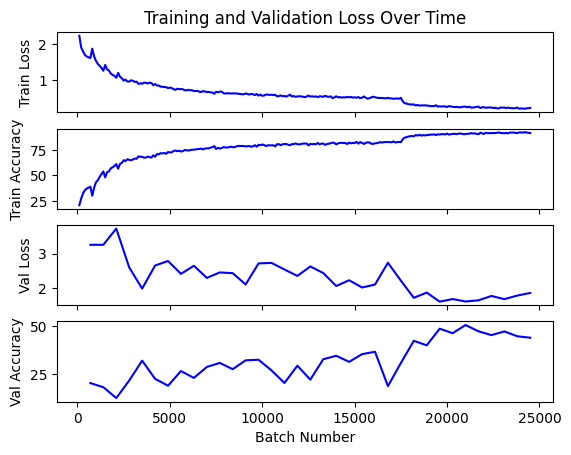

Epoch 36
Batch100, Loss: 0.221, Accuracy: 92.5%
Batch200, Loss: 0.225, Accuracy: 92.3%
Batch300, Loss: 0.219, Accuracy: 92.3%
Batch400, Loss: 0.212, Accuracy: 92.9%
Batch500, Loss: 0.205, Accuracy: 92.8%
Batch600, Loss: 0.209, Accuracy: 92.6%
Batch700, Loss: 0.214, Accuracy: 92.5%
Val Loss: 1.802, Val Accuracy: 44.5%
*****************************************



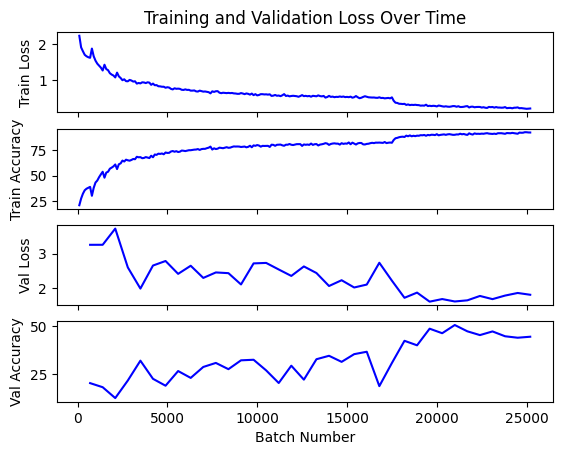

Epoch 37
Batch100, Loss: 0.206, Accuracy: 92.7%
Batch200, Loss: 0.213, Accuracy: 92.7%
Batch300, Loss: 0.219, Accuracy: 92.3%
Batch400, Loss: 0.200, Accuracy: 92.9%
Batch500, Loss: 0.206, Accuracy: 93.0%
Batch600, Loss: 0.205, Accuracy: 92.7%
Batch700, Loss: 0.213, Accuracy: 92.4%
Val Loss: 1.730, Val Accuracy: 46.5%
*****************************************



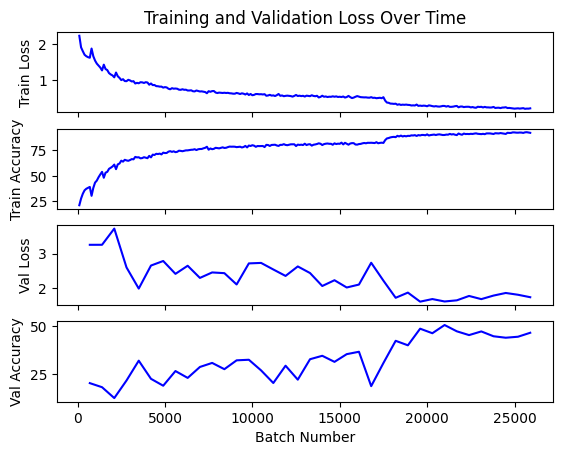

Epoch 38
Batch100, Loss: 0.207, Accuracy: 93.2%
Batch200, Loss: 0.217, Accuracy: 92.7%
Batch300, Loss: 0.214, Accuracy: 92.4%


KeyboardInterrupt: 

In [16]:
#Sets up CNN, optimizer, and loss function
resnet = Resnet()
resnet.to(device)
resnet.apply(he_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# Warmup: LR increases linearly from 1e-3 → 0.1 over 5 epochs
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, total_iters=5)

# Then switch to MultiStepLR
main_scheduler = MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)

# Combine the two
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[5])
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) #milestones [91, 136] as per paper
#optimizer = optim.Adam(resnet.parameters(), lr=0.0001)


batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the CNN
num_epochs = 45 #182 in the paper
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    resnet.train()
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)
    scheduler.step()

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}




In [11]:
for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")

Saved batches_training to Resnet1\batches_training.npy
Saved losses_training to Resnet1\losses_training.npy
Saved accuracies_training to Resnet1\accuracies_training.npy
Saved batches_validation to Resnet1\batches_validation.npy
Saved losses_validation to Resnet1\losses_validation.npy
Saved accuracies_validation to Resnet1\accuracies_validation.npy


In [13]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 47.54


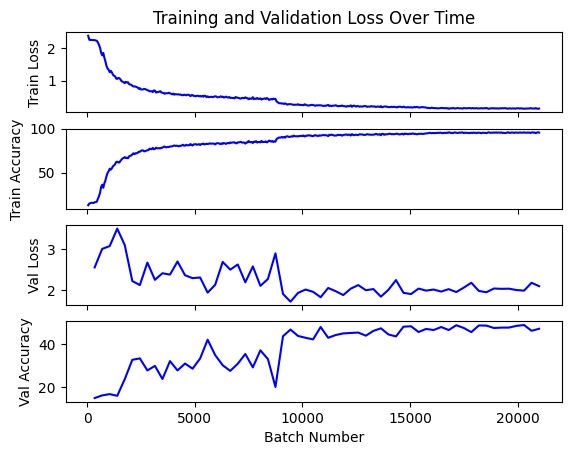

In [48]:
to_load = [
    "batches_training",
    "losses_training",
    "accuracies_training",
    "batches_validation",
    "losses_validation",
    "accuracies_validation"
]
batches_training = np.load(f'Resnet1/{to_load[0]}.npy')
losses_training = np.load(f'Resnet1/{to_load[1]}.npy')
accuracies_training = np.load(f'Resnet1/{to_load[2]}.npy')
batches_validation = np.load(f'Resnet1/{to_load[3]}.npy')
losses_validation = np.load(f'Resnet1/{to_load[4]}.npy')
accuracies_validation = np.load(f'Resnet1/{to_load[5]}.npy')

fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

In [ ]:
torch.save(resnet, 'DeepResNetParams.pth')

In [ ]:
#Loads previously trained models
with torch.serialization.safe_globals([Resnet]):
    resnet = torch.load('DeepResNetParams.pth', weights_only=False)
resnet.to(device)

In [3]:
test_iter = iter(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: truck


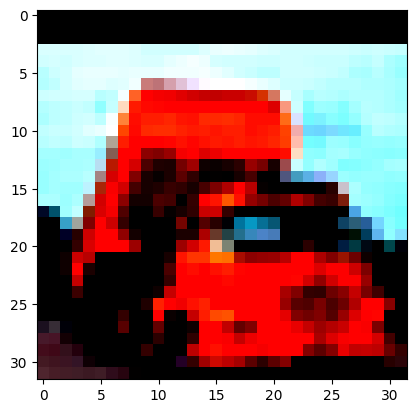

In [8]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
#resnet.train(False)
#guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
#guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]]}")
#print(f"Guess label: {class_names[guess_label]}")
plt.imshow(np_img.transpose((1, 2, 0)))